# Vectorized Reaction Networks and Simulations #

Vectorization in general is used for two reasons. First, it allows a few operations to run in parallel on a CPU,
or thousands of operations to run in parallel on a GPU. Secondly, it allows our large numerical computations to be
offloaded to highly optimized C language code, which is a large speed up even when parallelization isn't possible.

We also have a third reason specific to out use case. Since we will be doing gradient based optimization, we need to be
able to track a computation graph throughout the simulation. Doing this in python is possible but confusing and slow.
Therefore, we will make use of the PyTorch Modules, which provides highly optimized vectorized operations,
automatic differentiation and computation graph support, and some other useful numerical programming functionality.

From now on instead of using base python numerical types (`float`, `int`, etc.), we will be using `torch.Tensor` objects.
Since we will only need 1 and 2 dimensional objects, we can think of torch Tensors as matrices that also track all operations that are preformed on them.

In [11]:
import sys
sys.path.append("../../")
from steric_free_simulator import ReactionNetwork, VectorizedRxnNet, VecSim

from torch import DoubleTensor as Tensor  # forcing use of DoubleTensor (arrays of C float64 behind the scenes) because
                                          # high numerical precision is necessary for some gradient computations


### What is the vectorized reaction network ###

Essentially, we must represent all the information necessary for a simulation with torch tensors. We will do this as follows:

let $n$ be the number of states in the network, and $r$ be the number of forward reactions.

define:
- $M$ : a $(n \times 2r)$ matrix mapping from state space into reaction space. $M_{ij}=1$ if species $i$ is the product of
reaction $j$, $M_{ij} = -1$ if species $i$ is a reactant in reaction $j$, and is 0 everywhere else.
- $\vec k_{on}$ : a length $r$ vector of association constants
- $\vec s$ : a length $r$ vector of reaction scores (proportional to $\Delta G$)
- $\vec c$ : a length $n$ vector of species copy numbers.

A `VectorizedRxnNet` can be constructed from a vanilla `ReactionNetwork`. K_on's will be initialized to 1 if not provided. When parsing from an input file we load the file
into a `ReactionNetwork`, call `resolve_tree`, then can convert to a `VectorizedRxnNetwork`. This process is shown below.

In [9]:
rn = ReactionNetwork('./input_files/trimer.bngl', one_step=True)
rn.resolve_tree()
vec_rn = VectorizedRxnNet(rn, dev='cpu')

# print the c, s, and M objects
print('copies vector: ')
print(vec_rn.copies_vec)
print('\n Score vector: ')
print(vec_rn.rxn_score_vec)
print('\n M matrix: ')
print(vec_rn.M)


copies vector: 
tensor([5., 5., 5., 0., 0., 0., 0.], dtype=torch.float64)

 Score vector: 
tensor([ -5.,  10., -10., -15.,   0.,   5.], dtype=torch.float64)

 M matrix: 
tensor([[-1., -1.,  0.,  0.,  0., -1.,  1.,  1., -0., -0., -0.,  1.],
        [-1.,  0., -1., -1.,  0.,  0.,  1., -0.,  1.,  1., -0., -0.],
        [ 0., -1., -1.,  0., -1.,  0., -0.,  1.,  1., -0.,  1., -0.],
        [ 1.,  0.,  0.,  0., -1.,  0., -1., -0., -0., -0.,  1., -0.],
        [ 0.,  1.,  0., -1.,  0.,  0., -0., -1., -0.,  1., -0., -0.],
        [ 0.,  0.,  1.,  0.,  0., -1., -0., -0., -1., -0., -0.,  1.],
        [ 0.,  0.,  0.,  1.,  1.,  1., -0., -0., -0., -1., -1., -1.]],
       dtype=torch.float64)


Ok that's nice, but how do we run a simulation on this? The simulation is carried out using the VecSim class.

- first $\ln \vec K$ is computed. $\vec K$ is a vector of size $2r$, where indexes 0 to $r$ are forward reaction rate constants and positions $r$ to $2r$
are reverse reaction rate constants. $\vec k_{off}$ is first computed using $\vec k_{on}$ and $ \vec {\Delta  G}$ using equation
$\ln k_{off} = \frac {\Delta G} {RT} + \ln k_{on} + \ln c$ where c is the standard concentration. Then $\ln \vec k_{on}$ and
$\ln \vec k_{off}$ are concatenated to get $\ln \vec K$. This operation is preformed in
`VectorizedRxnNetwork.get_log_constants()`

- next a length $2r$ vector $\ln \vec C$ is computed using $M$ and $\vec c$. $\vec C$ contains the natural log of the products of the concentrations
of the reactants for each reaction. This vector is computed in `VectorizedRxnNetwork.get_log_copy_prod_vector()`

- we take element-wise sum of $\ln \vec K$ and $\ln \vec C$ to get $\ln \vec R$, the vector of the total rates for each
reaction at this time step.

- Compute the size of the time step $\Delta t = \frac {1} {\sum \exp \vec R} $

- compute the step size for each reaction $\vec r = \exp (\ln \Delta t + \vec R) $

- get the change in copies vector of size n, $\vec {\Delta c} = M \vec r$

- update the copy vector, $\vec c_{new} = \vec c + \vec {\Delta c}$

- repeat until the total simulation time is reached

- return the percent yield of the final complex

Using this approach simulation can be extremely fast, and are differentiable (more on that later). We will run this simulation for the trimer model below.


In [20]:
# initialize to k_on parameters since we didn't provide them in this input file.
vec_rn.reset()
sim = VecSim(vec_rn, runtime=1, score_constant=100, device='cpu')
final_yield = sim.simulate(verbose=True)

Using CPU


Let's plot the default observables:

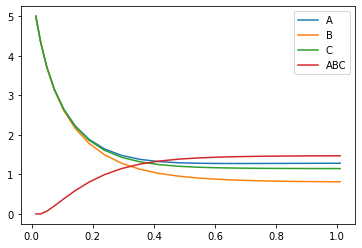

In [21]:
import numpy as np
from matplotlib import pyplot as plt

t = sim.steps
for key in sim.observables.keys():
    if key == 'steps':
        continue
    data = np.array(sim.observables[key][1])
    plt.plot(t, data, label=sim.observables[key][0])
lgnd = plt.legend(loc='best')
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
plt.show()


Next we will see how to use the optimizer class to do gradient based optimization of the association constants over
the simulations
